In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from modeling_functions import evaluate_model, plot_features_importance

df = pd.read_parquet('data/2023/for_ml_model.parquet')
df.set_index('Data Godzina', inplace=True)

RANDOM_STATE = 42
TEST_SIZE = 0.3
df_evaluate = pd.DataFrame()

# Feature selection

In [3]:
X = df[[
    'Godzinowe zużycie gd MWh',
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    'Święto',
    'Dzień tygodnia',
    'Godzina',
    'Miesiąc'
]]

y = df['Cena PLN/MWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

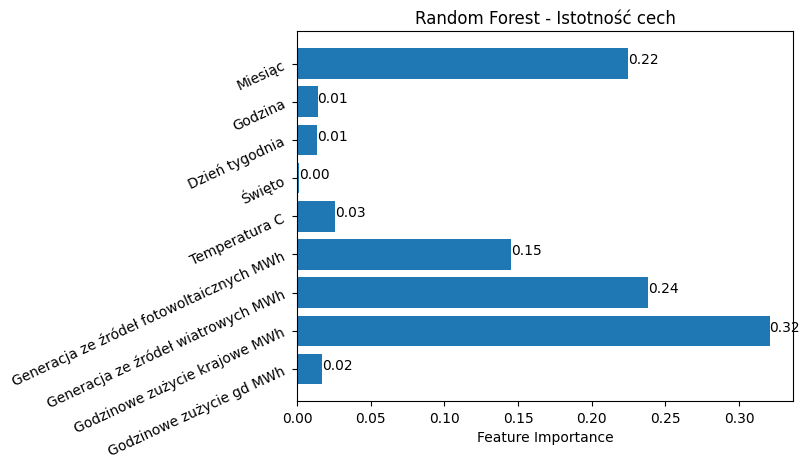

In [4]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

feature_importance = rf.feature_importances_
features = X.columns

plot_features_importance(features, feature_importance, 'Random Forest')


<Axes: >

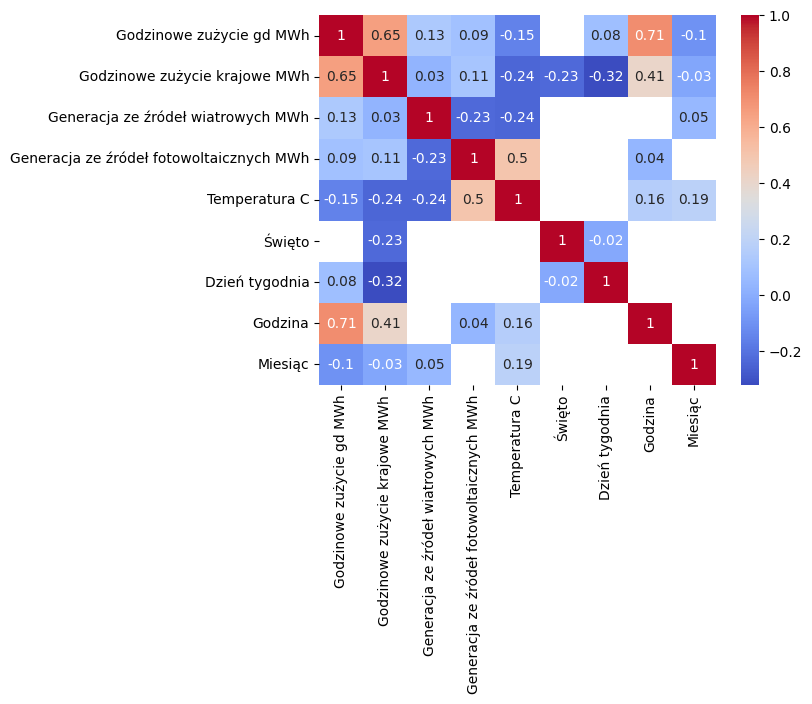

In [14]:
from scipy import stats

# Calculate correlation matrix
corr_matrix = X.corr(method='pearson').round(2)

# Calculate p-values matrix
p_values = pd.DataFrame(np.zeros_like(corr_matrix), columns=X.columns, index=X.columns)
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        if i != j:
            corr, p_value = stats.pearsonr(X.iloc[:, i], X.iloc[:, j])
            p_values.iloc[i, j] = p_value

# Create mask for significant correlations (p < 0.05)
mask = p_values > 0.05

# Plot heatmap with significance mask
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
# plt.title("Tablica korelacji Pearsona dla zmiennych objaśniających\n(dla p value < 0.05)")
# plt.tight_layout()

In [11]:
mask

,Godzinowe zużycie gd MWh,Godzinowe zużycie krajowe MWh,Generacja ze źródeł wiatrowych MWh,Generacja ze źródeł fotowoltaicznych MWh,Temperatura C,Święto,Dzień tygodnia,Godzina,Miesiąc
Godzinowe zużycie gd MWh,False,False,False,False,False,True,False,False,False
Godzinowe zużycie krajowe MWh,False,False,False,False,False,False,False,False,False
Generacja ze źródeł wiatrowych MWh,False,False,False,False,False,True,True,True,False
Generacja ze źródeł fotowoltaicznych MWh,False,False,False,False,False,True,True,False,True
Temperatura C,False,False,False,False,False,True,True,False,False
Święto,True,False,True,True,True,False,False,True,True
Dzień tygodnia,False,False,True,True,True,False,False,True,True
Godzina,False,False,True,False,False,True,True,False,True
Miesiąc,False,False,False,True,False,True,True,True,False


In [10]:
p_values

,Godzinowe zużycie gd MWh,Godzinowe zużycie krajowe MWh,Generacja ze źródeł wiatrowych MWh,Generacja ze źródeł fotowoltaicznych MWh,Temperatura C,Święto,Dzień tygodnia,Godzina,Miesiąc
Godzinowe zużycie gd MWh,0.000000e+00,0.000000e+00,8.649813e-33,1.520371e-15,3.172071e-47,5.565152e-02,1.304190e-12,0.000000e+00,4.588884e-22
Godzinowe zużycie krajowe MWh,0.000000e+00,0.000000e+00,1.006967e-02,3.651960e-27,1.685753e-114,2.154114e-109,1.630828e-207,0.000000e+00,1.358523e-03
Generacja ze źródeł wiatrowych MWh,8.649813e-33,1.006967e-02,0.000000e+00,1.839662e-106,9.041562e-119,8.039991e-02,8.064819e-02,4.440463e-01,2.830578e-06
Generacja ze źródeł fotowoltaicznych MWh,1.520371e-15,3.651960e-27,1.839662e-106,0.000000e+00,0.000000e+00,4.039165e-01,7.469987e-01,6.630660e-05,6.644950e-01
Temperatura C,3.172071e-47,1.685753e-114,9.041562e-119,0.000000e+00,0.000000e+00,4.277931e-01,8.574686e-01,2.955723e-48,2.546156e-73
Święto,5.565152e-02,2.154114e-109,8.039991e-02,4.039165e-01,4.277931e-01,0.000000e+00,3.190221e-02,1.000000e+00,9.516068e-01
Dzień tygodnia,1.304190e-12,1.630828e-207,8.064819e-02,7.469987e-01,8.574686e-01,3.190221e-02,0.000000e+00,1.000000e+00,2.165073e-01
Godzina,0.000000e+00,0.000000e+00,4.440463e-01,6.630660e-05,2.955723e-48,1.000000e+00,1.000000e+00,0.000000e+00,9.762539e-01
Miesiąc,4.588884e-22,1.358523e-03,2.830578e-06,6.644950e-01,2.546156e-73,9.516068e-01,2.165073e-01,9.762539e-01,0.000000e+00


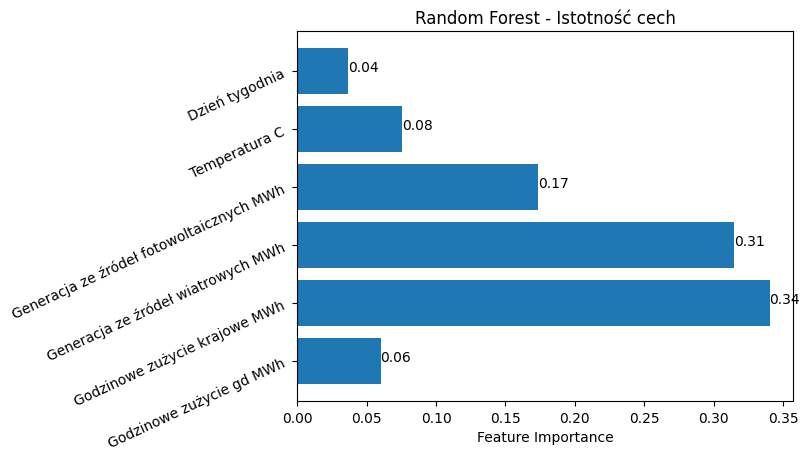

In [28]:
X = df[[
    'Godzinowe zużycie gd MWh',
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    # 'Święto',
    'Dzień tygodnia',
    # 'Godzina',
    # 'Miesiąc'
]]

y = df['Cena PLN/MWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

feature_importance = rf.feature_importances_
features = X.columns

plot_features_importance(features, feature_importance, 'Random Forest')

# 2 uczenie

In [29]:
X = df[[
    'Godzinowe zużycie gd MWh',
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    'Dzień tygodnia',
]]

y = df['Cena PLN/MWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 2.1 Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Las losowy", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Las losowy,True,0.79,61.45,80.7


## 2.2 Support Vector Machine (SVM)

### Strojenie hiperparametrów

In [30]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# attempt 1
param_grid = {
    'svr__C': [
        1, 10, 50, 100, 200, 500, 1000
    ],
    'svr__gamma': [0.1, 1, 2, 3],
    'svr__epsilon': [1, 10, 30, 60, 90]
}
svr = make_pipeline(StandardScaler(), SVR())
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)


c:\python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'svr__C': 500, 'svr__epsilon': 30, 'svr__gamma': 1}


In [31]:
# attempt 2
param_grid = {
    'svr__C': [
         300, 400, 500, 600, 700
    ],
    'svr__gamma': [0.5, 1, 1.5],
    'svr__epsilon': [10, 20, 30, 40]
}
svr = make_pipeline(StandardScaler(), SVR())
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'svr__C': 400, 'svr__epsilon': 30, 'svr__gamma': 1.5}


In [13]:
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))
# svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=150, gamma=1))
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Support Vector Machine", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Las losowy,True,0.79,61.45,80.70
0,Support Vector Machine,True,0.80,58.37,79.84


## 2.3 Gradient Boosting Machines (GBM)

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Gradient Boosting Machines", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Las losowy,True,0.79,61.45,80.70
0,Support Vector Machine,True,0.80,58.37,79.84
0,Gradient Boosting Machines,True,0.74,72.12,90.03


# Final training

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from modeling_functions import evaluate_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


df = pd.read_parquet('data/2023/for_ml_model.parquet')
# df.set_index('Data Godzina', inplace=True)

RANDOM_STATE = 41
TEST_SIZE = 0.3
df_evaluate = pd.DataFrame()


def create_model_random_forest(X_train, y_train):
    # Initialize and train Random Forest models
    rf = RandomForestRegressor(random_state=RANDOM_STATE)
    # Fit data
    rf.fit(X_train, y_train)

    return rf

def create_model_svm(X_train, y_train):
    # Standardize features and train SVM
    svr = make_pipeline(StandardScaler(), SVR(C=400, gamma=1.5, epsilon=30))
    # Fit data
    svr.fit(X_train, y_train)

    return svr

def create_model_gbm(X_train, y_train):
    gbm = GradientBoostingRegressor(random_state=RANDOM_STATE)
    # Fit data
    gbm.fit(X_train, y_train)
    
    return gbm

def create_model_mlp(X_train, y_train):

    mlp = MLPRegressor(random_state=RANDOM_STATE)
    mlp.fit(X_train, y_train)
    
    return mlp

def train_models_and_compare(df: pd.DataFrame, X_columns: list, with_gd: bool):
    X = df[X_columns].copy()
    y = df['Cena PLN/MWh']
    
    df_evaluate = pd.DataFrame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    rf_model = create_model_random_forest(X_train, y_train)
    svm_model = create_model_svm(X_train, y_train)
    gbm_model = create_model_gbm(X_train, y_train)
    # mlp_model = create_model_mlp(X_train, y_train)
    
    y_pred_rf = rf_model.predict(X_test)
    y_pred_svm = svm_model.predict(X_test)
    y_pred_gbr = gbm_model.predict(X_test)
    # y_pred_mlp = mlp_model.predict(X_test)

    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_rf, "Random Forest", with_gd)
    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_gbr, "Gradient Boosting Regressor", with_gd)
    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_svm, "Support Vector Machine", with_gd)
    # df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_mlp, "Neural network", with_gd)
    
    return df_evaluate

In [2]:
X_gd_columns = [
    'Godzinowe zużycie gd MWh',
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Dzień tygodnia',
    'Temperatura C',
]

X_no_gd_columns = [
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Dzień tygodnia',
    'Temperatura C',
]

df_evaluate_no_gd = train_models_and_compare(df, X_no_gd_columns, with_gd=False)
df_evaluate_with_gd = train_models_and_compare(df, X_gd_columns, with_gd=True)


In [3]:
df_result = pd.concat([df_evaluate_no_gd, df_evaluate_with_gd]).reset_index(drop=True).sort_values('Model')
df_result

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
1,Gradient Boosting Regressor,False,0.73,72.19,90.21
4,Gradient Boosting Regressor,True,0.74,70.85,89.04
0,Random Forest,False,0.80,59.21,78.73
3,Random Forest,True,0.81,57.52,76.51
2,Support Vector Machine,False,0.80,56.35,77.94
5,Support Vector Machine,True,0.82,53.51,74.03


### Walidacja krzyżowa najlepszego modelu

In [52]:
from sklearn.model_selection import cross_val_score

y = df['Cena PLN/MWh']
X = df[X_gd_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


best_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_svr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Display cross-validation results
print("Cross-validation R^2 scores:", cv_scores)
print("Mean R^2 score:", cv_scores.mean())
print("Standard deviation of R^2 scores:", cv_scores.std())

Cross-validation R^2 scores: [0.82834571 0.83750197 0.83148885 0.83606397 0.8242321 ]
Mean R^2 score: 0.8315265217625365
Standard deviation of R^2 scores: 0.004891258314324354
